In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt

In [7]:
results = pd.read_csv('results_segmentation.csv')
results_05 = pd.read_csv('results_segmentation0.5.csv')
results_07 = pd.read_csv('results_segmentation0.7.csv')
results_09 = pd.read_csv('results_segmentation0.9.csv')
results_095 = pd.read_csv('results_segmentation0.95.csv')

1.0
0.9417989417989417
0.6503496503496503
0.23255813953488372
0.0
0.0


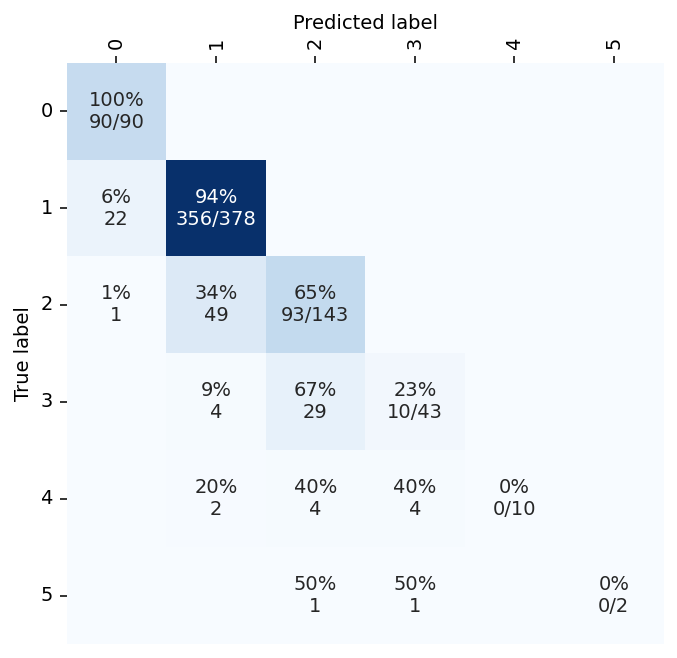

In [52]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(results):
    """
        Print confusion matrix with accuracy for each class.
        Takes single image.
        :param results: dataframe with results (count and prediction columns)
        :return:
    """
    y_true = results['count']
    y_pred = results['prediction']
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.0f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.0f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    fig, ax = plt.subplots(figsize=(5.5, 5.5), dpi=140)
    sn.heatmap(cm, cmap= "Blues", annot=annot, fmt='', ax=ax, cbar=False)
    plt.yticks(rotation=0)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=90)
    plt.plot()
    plt.show()
    
print_confusion_matrix(results_095)

In [19]:
from sklearn import metrics

def print_acc(results):
    y_true = results['count']
    y_pred = results['prediction']
    return metrics.accuracy_score(y_true, y_pred)

round(print_acc(results_095), 2)

0.82

In [20]:
def print_decision_acc(results):
    y_true = results['count']
    y_pred = results['prediction']
    acc = 0
    for i, y in enumerate(y_true):
        if (y == 1 and y_pred[i] == 1) or (y != 1 and y_pred[i] != 1):
            acc += 1
    return acc / len(y_true)

round(print_decision_acc(results_095), 2)

0.88

In [42]:
df_test = pd.read_csv('/home/p22g5/AnomaliesRecycling/data/test.csv')
df_test = pd.merge(df_test, results_05,  how='left', left_on=['name','count'], right_on = ['name','count']).rename(columns={'prediction': 'pred'})
df_test['is_correct'] = df_test.apply(lambda row: row['count'] == row['pred'], axis=1)

In [43]:
df_test_miss = df_test[~df_test['is_correct']].copy().drop(columns=['is_correct'])
df_test_miss.head()

,name,count,edge,different colors,one color,transparent,inside,overlapping,dark color,open lid,pred
2,cluttered/Anlerndaten (830).jpg,2,1,1,0,0,0,0,0,0,1
20,cluttered/Anlerndaten (460).jpg,3,0,1,0,0,0,1,0,0,2
27,harder_samples/Anlernbilder (154).jpg,5,0,1,0,0,0,1,0,0,3
40,harder_samples/Anlernbilder (338).jpg,3,0,1,0,0,0,1,1,0,2
43,cluttered/Anlerndaten (875).jpg,2,0,1,0,0,0,1,1,0,1


In [44]:
columns = ['edge', 'different colors', 'one color', 'transparent', 'inside', 'overlapping', 'dark color',
           'open lid']

def bar_plot(ax, data, preds, colors=None, total_width=0.8, single_width=1, legend=True, count=0):
    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax.set_xticks(range(len(preds)))
    ax.set_xticklabels(preds)
    ax.set_xlabel('Predicted label')
    ax.set_title(f'Label: {count}')
    ax.grid(False)
    
def get_obj(count):
    obj = dict.fromkeys(columns, [])
    preds = []
    for pred in range(6):
        df_pred = df_test[(df_test['count'] == count) & (df_test['pred'] == pred)]
        df = df_pred[columns].sum().to_frame()
        if df.sum().tolist()[0] == 0:
            continue
        df[0] = df[0].apply(lambda x: 100 * x/len(df_pred.index))
        df = df.reset_index()
        df_dict = df.to_dict('records')
        for row in df_dict:
            obj[row['index']] = obj[row['index']] + [row[0]]
        preds.append(pred)
    
    fig, ax = plt.subplots(dpi=140)
    bar_plot(ax, obj, preds, total_width=.8, single_width=.9, count=count)
    fig.tight_layout()
    plt.show()

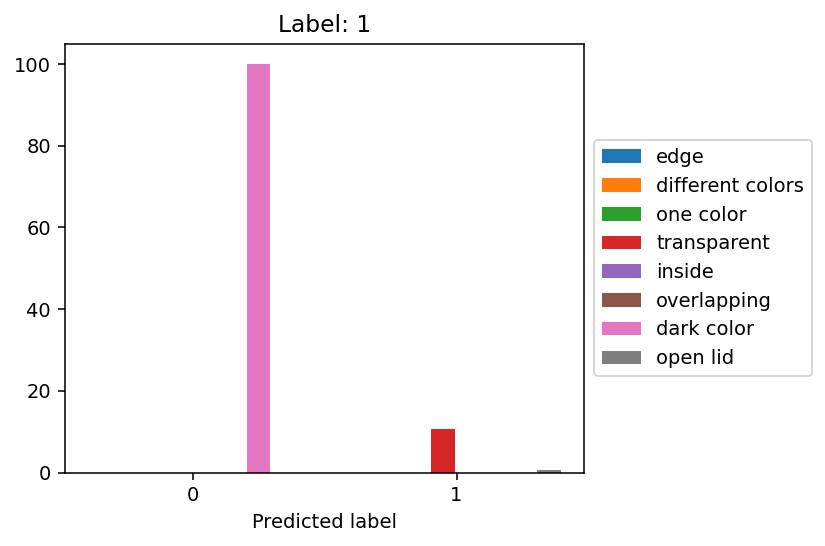

In [48]:
get_obj(count=1)